In [1]:
from keras.models import load_model
import numpy as np
import json
from itertools import chain
from collections import Counter, OrderedDict
import pandas as pd

Using TensorFlow backend.


In [31]:
books = pd.read_csv('../saved_embeddings/three_dims/page_names.tsv', sep='\t', header=None)[0].to_list()
book_weights = pd.read_csv('../saved_embeddings/three_dims/page_embedding.tsv', sep='\t', header=None).values

links = pd.read_csv('../saved_embeddings/three_dims/link_names.tsv', sep='\t', header=None)[0].to_list()
link_weights = pd.read_csv('../saved_embeddings/three_dims/link_embedding.tsv', sep='\t', header=None).values


In [32]:
books = [b.replace(" (langage)", "") for b in books]

In [33]:
book_index = {book: idx for idx, book in enumerate(books)}
index_book = {idx: book for book, idx in book_index.items()}

link_index = {link: idx for idx, link in enumerate(links)}
index_link = {idx: link for link, idx in link_index.items()}

## Add stackshare info
to get the category of the tool

In [5]:
import json
from difflib import get_close_matches

with open("../../../stackshare_tools_categories.json", 'r') as f:
    stackshare = json.load(f)

books_w_cat = {}
for k,v in stackshare.items():
    book_k = get_close_matches(k, books, n=1, cutoff=0.9)
    if book_k:
        books_w_cat[book_k[0]] = v

r_books_w_cat = {}
for k,v in books_w_cat.items():
    if not v in r_books_w_cat.keys():
        r_books_w_cat[v] = [k]
    else:
        r_books_w_cat[v].append(k)

In [49]:
# r_books_w_cat["Frameworks (Full Stack)"]
# r_books_w_cat["Javascript UI Libraries"]
# r_books_w_cat["Languages"]
# r_books_w_cat["Databases"]

### Function to Find Most Similar Entities
The function below takes in either a book or a link, a set of embeddings, and returns the n most similar items to the query. It does this by computing the dot product between the query and embeddings. Because we normalized the embeddings, the dot product represents the cosine similarity between two vectors. This is a measure of similarity that does not depend on the magnitude of the vector in contrast to the Euclidean distance. (The Euclidean distance would be another valid metric of similary to use to compare the embeddings.)

Once we have the dot products, we can sort the results to find the closest entities in the embedding space. With cosine similarity, higher numbers indicate entities that are closer together, with -1 the furthest apart and +1 closest together.

In [41]:
def filter_by_cat(name, weights, index_name):
    if index_name == 'book':
        cat = books_w_cat[name]
        sub_books = r_books_w_cat[cat]
        n_weights = []
        for n in sub_books:
            n_weights.append(weights[book_index[n]])
        n_book_index = {book: idx for idx, book in enumerate(sub_books)}
        n_index_book = {idx: book for book, idx in n_book_index.items()}
        return n_book_index, n_index_book, n_weights

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 15

def find_similar(name, weights, index_name = 'book', n = 10, least = False, return_dist = False, plot = False):
    """Find n most similar items (or least) to name based on embeddings. Option to also plot the results"""
    
    # Select index and reverse index
    if index_name == 'book':
        index = book_index
        rindex = index_book
    elif index_name == 'page':
        index = link_index
        rindex = index_link
    
    index, rindex, weights = filter_by_cat(name, weights, index_name)
    # Check to make sure `name` is in index
    try:
        # Calculate dot product between book and all others
        dists = np.dot(weights, weights[index[name]])
    except KeyError:
        print(f'{name} Not Found.')
        return
    
    # Sort distance indexes from smallest to largest
    sorted_dists = np.argsort(dists)
    
    # Plot results if specified
    if plot:
        
        # Find furthest and closest items
        furthest = sorted_dists[:(n // 2)]
        closest = sorted_dists[-n-1: len(dists) - 1]
        items = [rindex[c] for c in furthest]
        items.extend(rindex[c] for c in closest)
        
        # Find furthest and closets distances
        distances = [dists[c] for c in furthest]
        distances.extend(dists[c] for c in closest)
        
        colors = ['r' for _ in range(n //2)]
        colors.extend('g' for _ in range(n))
        
        data = pd.DataFrame({'distance': distances}, index = items)
        
        # Horizontal bar chart
        data['distance'].plot.barh(color = colors, figsize = (10, 8),
                                   edgecolor = 'k', linewidth = 2)
        plt.xlabel('Cosine Similarity');
        plt.axvline(x = 0, color = 'k');
        
        # Formatting for italicized title
        name_str = f'{index_name.capitalize()}s Most and Least Similar to'
        for word in name.split():
            # Title uses latex for italize
            name_str += ' $\it{' + word + '}$'
        plt.title(name_str, x = 0.2, size = 28, y = 1.05)
        
        return None
    
    # If specified, find the least similar
    if least:
        # Take the first n from sorted distances
        closest = sorted_dists[:n]
         
        print(f'{index_name.capitalize()}s furthest from {name}.\n')
        
    # Otherwise find the most similar
    else:
        # Take the last n sorted distances
        closest = sorted_dists[-n:]
        
        # Need distances later on
        if return_dist:
            return dists, closest
        
        
        print(f'{index_name.capitalize()}s closest to {name}.\n')
        
    # Need distances later on
    if return_dist:
        return dists, closest
    
    
    # Print formatting
    max_width = max([len(rindex[c]) for c in closest])
    
    # Print the most similar and distances
    for c in reversed(closest):
        print(f'{index_name.capitalize()}: {rindex[c]:{max_width + 2}} Similarity: {dists[c]:.{2}}')

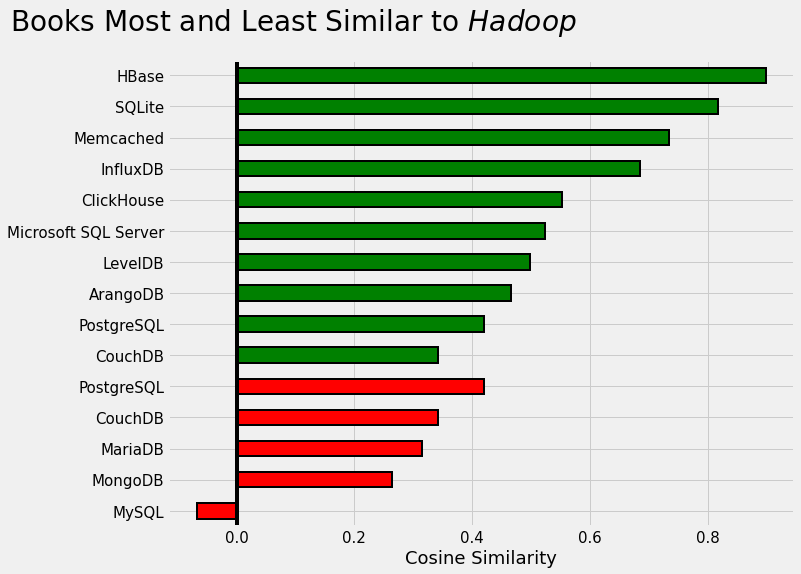

In [62]:
find_similar('Hadoop', book_weights, plot=True)

In [ ]:
find_similar('Python (langage)', book_weights, plot=True)

In [ ]:
find_similar('Pandas', book_weights, plot=True)

In [ ]:
find_similar('NumPy', book_weights, plot=True)

### Wikilink Embeddings
We also have the embeddings of wikipedia links (which are themselves Wikipedia pages). We can take a similar approach to extract these and find the most similar to a query page.

In [ ]:
find_similar('c (langage)', link_weights, index_name = 'page', plot=True)

In [ ]:
find_similar('java (langage)', link_weights, index_name = 'page', plot=True)

In [ ]:
model_class = load_model(models_dir + 'first_attempt_lang_class.h5')

In [ ]:
book_weights_class = extract_weights('book_embedding', model_class)
book_weights_class.shape

In [ ]:
find_similar('Python (langage)', book_weights_class, plot=True)

In [ ]:
find_similar('NumPy', book_weights_class, plot=True)

In [ ]:
find_similar('Brainfuck', book_weights_class, plot=True)

In [ ]:
link_weights_class = extract_weights('link_embedding', model_class)

In [ ]:
find_similar('r (langage)', link_weights_class, index_name = 'page', plot=True)

In [ ]:
find_similar('python (langage)', link_weights_class, index_name = 'page', plot=True)

## Visualizations
One of the most interesting parts about embeddings is that we can use them to visualize concepts such as War and Peace or biography. First we have to take the embeddings from 50 dimensions down to either 3 or 2. We can do this using pca, tsne, or umap. We'll try both tsne and umap for comparison. TSNE takes much longer and is designed to retain local structure within the data. UMAP is generally quicker and is designed for a balance between local and global structure in the embedding.

### Manifold Embeddings
TSNE: t-Stochastic Distributed Neighbors Embedding, and UMAP: Uniform Manifold Approximation and Projection, are both methods that use the idea of a manifold to map vectors to a lower dimensional embedded space. Therefore, we are taking the 37,000 dimensions in the case of books, embedding them to 50 dimensions with the neural network, and then embedding them down to 2 dimensions with a manifold. The primary idea behind dimension reduction with a manifold is that there is a lower dimensional representation of the vectors that can still capture the variation between different groups. We want the embeddings to represent similar entities close to one another but in fewer dimensions that allow us to visualize the entities.

In [ ]:
from sklearn.manifold import TSNE
from umap import UMAP

In [ ]:
def reduce_dim(weights, components = 3, method = 'tsne'):
    """Reduce dimensions of embeddings"""
    if method == 'tsne':
        return TSNE(components, metric = 'cosine').fit_transform(weights)
    elif method == 'umap':
        # Might want to try different parameters for UMAP
        return UMAP(n_components=components, metric = 'cosine', 
                    init = 'random', n_neighbors = 5).fit_transform(weights)

In [ ]:
book_r = reduce_dim(book_weights_class, components = 2, method = 'tsne')
book_r.shape

In [ ]:
from IPython.core.interactiveshell import InteractiveShell

# Set shell to show all lines of output
# InteractiveShell.ast_node_interactivity = 'all'
InteractiveShell.ast_node_interactivity = 'last'

plt.figure(figsize = (10, 8))
plt.plot(book_r[:, 0], book_r[:, 1], 'r.')
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Items Embeddings Visualized with TSNE');

In [ ]:
book_ru = reduce_dim(book_weights_class, components = 2, method = 'umap')

plt.figure(figsize = (10, 8))
plt.plot(book_ru[:, 0], book_ru[:, 1], 'g.');
plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2'); plt.title('Book Embeddings Visualized with UMAP');

In [ ]:
info = list(chain(*[set(book[1]) for book in books]))
info_counts = count_items(info)
list(info_counts.items())[:10]

In [ ]:
genres = [book[1].get('paradigme', 'None').lower() for book in books]

# Remove genres not found
genre_counts = count_items(genres)
del genre_counts['none']
list(genre_counts.items())[:10]

In [ ]:
genre_to_include = list(genre_counts.keys())[:10]
idx_include = []
genres = []

for i, book in enumerate(books):
    if 'paradigme' in book[1].keys():
        if book[1]['paradigme'].lower() in genre_to_include:
            idx_include.append(i)
            genres.append(book[1]['paradigme'].capitalize())

In [ ]:
ints, gen = pd.factorize(genres)
gen[:5]

In [ ]:
plt.figure(figsize = (10, 8))

# Plot embedding
plt.scatter(book_r[idx_include, 0], book_r[idx_include, 1], 
            c = ints, cmap = plt.cm.tab10)

# Add colorbar and appropriate labels
cbar = plt.colorbar()
cbar.set_ticks([])
for j, lab in enumerate(gen):
    cbar.ax.text(10, j * 0.9 + 0.5, lab, ha='left', va='center')
cbar.ax.set_title('Paradigme', loc = 'left')


plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('TSNE Visualization of Book Embeddings');

In [ ]:
plt.figure(figsize = (10, 8))

# Plot embedding
plt.scatter(book_ru[idx_include, 0], book_ru[idx_include, 1], 
            c = ints, cmap = plt.cm.tab10)

# Add colorbar and appropriate labels
cbar = plt.colorbar()
cbar.set_ticks([])
for j, lab in enumerate(gen):
    cbar.ax.text(10, j * 0.9 + 0.5, lab, ha='left', va='center')
cbar.ax.set_title('Paradigme', loc = 'left')


plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2'); plt.title('UMAP Visualization of Book Embeddings');

### Most Popular Books in Embedding
Let's see the embedding labeled with the 10 books most often mentioned by other books.

In [ ]:
def plot_by_attribute(attribute):
    """Color book embedding by `attribute`"""
    # Find all the attribute values
    attrs = [book[1].get(attribute, 0) for book in books]

    # Remove attributes not found
    attr_counts = count_items(attrs)
    del attr_counts[0]
    
    # Include 10 most popular attributes
    attr_to_include, counts = list(attr_counts.keys())[:10], list(attr_counts.values())[:10]
    
    idx_include = []
    attributes = []

    # Iterate through books searching for the attribute
    for i, book in enumerate(books):
        # Limit to books with the attribute
        if attribute in book[1].keys():
            # Limit to attribute in the 10 most popular
            if book[1][attribute] in attr_to_include:
                idx_include.append(i)
                attributes.append(book[1][attribute])
                
    # Map to integers
    ints, attrs = pd.factorize(attributes)
    plt.figure(figsize = (12, 10))

    plt.scatter(book_r[:, 0], book_r[:, 1], marker = '.', color = 'lightblue', alpha = 0.2)
    
    # Plot embedding with only specific attribute highlighted
    plt.scatter(book_r[idx_include, 0], book_r[idx_include, 1], alpha = 0.6,
                c = ints, cmap = plt.cm.tab10, marker = 'o', s = 50)

    # Add colorbar and appropriate labels
    cbar = plt.colorbar()
    cbar.set_ticks([])
    tick_labels = [f'{attr}: {count}' for attr, count in zip(attr_to_include, counts)]
    # Labeling
    for j, lab in enumerate(tick_labels):
        cbar.ax.text(10, j * 0.9 + 0.5, lab, ha='left', va='center')
    cbar.ax.set_title(f'{attribute.capitalize()}: Count', loc = 'left')


    plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title(f'Item Embeddings with {attribute.capitalize()}');

In [ ]:
plot_by_attribute('développeur')

In [ ]:
plot_by_attribute('licence')

In [ ]:
plot_by_attribute('date de première version')

### Pages Visualization
Let's look at reducing the dimension of the embedding for the wikilinks. We'll then visualize them in the same way as with the books.

In [ ]:
link_r = reduce_dim(link_weights_class, components = 2, method = 'tsne')
link_r.shape

In [ ]:
idx_to_include = [idx for link, idx in link_index.items() if 'catégorie:' in link]

categories = []

for book in books:
    for link in book[2]:
        if 'catégorie:' in link.lower():
            categories.append(link)
            
c_counts = count_items(categories)
list(c_counts.items())[:5]

In [ ]:
idx = []

# Find the index of the most popular links
for link in list(c_counts.keys())[:10]:
    link_idx = link_index[link.lower()]
    
    # Find index of category 
    index = int(np.where(np.array(idx_to_include) == link_idx)[0])
    idx.append(index)

In [ ]:
plt.figure(figsize = (12, 12))
plt.scatter(link_r[:, 0], link_r[:, 1], alpha = 0.6)

for i in idx:
    x, y = link_r[i, 0], link_r[i, 1]
    s = index_link[idx_to_include[i]].split(':')[-1]
    _ = plt.text(x, y, s, fontsize = 18);
    
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Wikilinks Category Embedding Visualized with TSNE');